# KSA: Polar Observations and Modelling

# Week 5 - Hydrographic sections

<div style="float: right; margin-right: 20px; margin-left: 30px; width: 30%; max-width: 500px;">
    <img src="images/zonal_schematic.png" width="100%"/>
</div>

In `1_Building_a_cross_section.ipynb` we have used GO-SHIP's Easy Ocean gridded product for I09S and we have tried to replicate the product using the CTD stations from the most recent I09S occupation from the MISO voyage in February 2024. Hopefully, you know have a dataset for this last occupation that contains temperature, conservative temperature, practical and absolute salinity and oxygen variables. If not, you can use on we have prepared called `i09s_2024.nc` in the `data` directory.

Now that we are done with the more "technical" part of the work, we can try to do something a bit more research focused. We will use the hydrographic sections to look at decadal changes in Antarctic Bottom Water, or AABW. AABW is the densest water mass globally, and as such it is found at the bottom of the ocean basins, not just around Antarctica, but throughout the global ocean. AABW is formed in a few polynyas along the Antarctic continental margins. Polynyas are essentially large, persistent "holes" in sea ice that leave the surface of the ocean exposed to the atmosphere. Remember that in these polar regions the ocean surface is much warmer than the air at the surface, and so in these polynyas, without the insulating effect of sea ice, the ocean rapidly looses heat to the atmosphere. This rapid heat loss cools the surface and triggers sea ice formation, a process in which salt cristals are rejected and remain in the liquid water. Therefore the surface ocean in polynyas is both cooling and becoming saltier. Which acts to increase its density!

The densification in the surface layers drives deep convection, where this newly formed water mass sinks to the bottom, and spills over the continental shelf, filling the bottom of the ocean. This process is schematised in the figure on the right by the darkest blue water. The figure is part of a [review of Southern Ocean dynamics](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2022RG000781), which is a great reference for any of your queries! 

<div style="float: left; margin-right: 20px; margin-left: 30px; width: 30%; max-width: 500px;">
    <img src="images/AABW_pathways.jpg" width="100%"/>
</div>

AABW is a very important water mass. It's formation happens only in a [handful of places](https://www.nature.com/articles/ngeo1743) around the Antarctic margins, it brings freshly ventilated waters high in oxygen to the bottom, and more importantly it is one of the processes by which the ocean stores anthropogenic carbon. Changes in AABW are a good "thermometer" to infer how far into the warming path we are. Therefore, monitoring the AABW layer is one of the priorities of our long-term observational system. 

We will use the four I09S occupations to look at changes in the AABW layer in the region. The figure on the right, from [van Wijk, E. M. and & Rintoul, S. R. (2014)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2013GL058921) shows the pathways of AABW in the region. In the Australian Antarctic basin AABW comes from two source regions: the Adelie land and the Ross Sea. Each of these regions produces their own "flavour" of AABW, called Adelie Land Bottom Water (ALBW) and Ross Sea Bottom Water (RSBW). These flavours are distinguished from relatively small variations in salinity and oxygen content. 

As you can see, since AABW flows along the bottom of the ocean, its pathways are limited and steered by topography. In order to flow north, it has to go through some deep passages in the mid-ocean ridge.

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cft
import cmocean as cm
import glob
import gsw
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import metpy
import numpy as np
import xarray as xr

# Identifying the AABW layer

Let's open the historic occupations from Easy Ocean, and merge in the latest 2024 occupation that we created in `1_Building_a _cross_section.ipynb`:

In [3]:
I09S = xr.open_dataset('/home/561/jn8053/g_jk72/KSA_Observations_Modelling/Class2/data/i09s.nc')
I09S_2024 = xr.open_dataset('/home/561/jn8053/g_jk72/KSA_Observations_Modelling/Class2/data/i09s_2024.nc')

# Merge using a concatenation along the dimension "gridded_section"
I09S = xr.concat([I09S, I09S_2024], dim = 'gridded_section')

In [4]:
I09S

<xarray.Dataset> Size: 32MB
Dimensions:                   (gridded_section: 4, longitude: 1, latitude: 311,
                               pressure: 651)
Coordinates:
  * gridded_section           (gridded_section) float64 32B 1.0 2.0 3.0 4.0
  * longitude                 (longitude) float64 8B 114.7
  * latitude                  (latitude) float64 2kB -65.4 -65.3 ... -34.5 -34.4
  * pressure                  (pressure) float64 5kB 0.0 10.0 ... 6.5e+03
Data variables:
    temperature               (pressure, latitude, longitude, gridded_section) float64 6MB ...
    practical_salinity        (pressure, latitude, longitude, gridded_section) float64 6MB ...
    oxygen                    (pressure, latitude, longitude, gridded_section) float64 6MB ...
    conservative_temperature  (pressure, latitude, longitude, gridded_section) float64 6MB ...
    absolute_salinity         (pressure, latitude, longitude, gridded_section) float64 6MB ...
Attributes: (12/36)
    program:                       GO-Ship Easy Ocean. WOCE and GO-Ship gridd...
    Conventions:                   CF-1.7 ACDD-1.3
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         Gridded CTD product from WOCE and GO-Ship ...
    date_issued:                   20230927
    abstract:                      Ship-based hydrographic data are essential...
    ...                            ...
    creator_email:                 k.katsumata@jamstec.go.jp
    lineage:                       Data were created as described at: https:/...
    citation:                      The citation in a list of references is: "...
    acknowledgement:               Data were collected and made publicly avai...
    disclaimer:                    Data, products and services from CCHDO are...
    license:                       http://creativecommons.org/licenses/by/4.0/

We have a nice and tidy dataset to work with. Now we need a criteria with which to identify the AABW layer!

Remember that water masses are usually defined by their properties: temperature, salinity, density, etc. For example, in the Southern Ocean, Circumpolar Deep Water is that water warmer than 1.5$^{\circ}$C.

AABW is defined by a specific value of *neutral density*, 28.27 kg/m$^3$. Neutral density, also referred to as $\gamma$ is calculated by referrencing potential density surfaces to hydrographic data. The usage of neutral density is widespread, but it's calculation is not trivial. For the sake of this tutorial, we will provide you neutral densities calculated for I09S. These are in `data/i09s_neutral_density.nc`.

Let's open the neutral density dataset and add it to our `I09S` one:

In [5]:
neutral_density = xr.open_dataset('/home/561/jn8053/g_jk72/KSA_Observations_Modelling/Class2/data/i09s_neutral_density.nc')

In [6]:
I09S = xr.merge([I09S, neutral_density])

Amazing.

Let's begin by plotting a cross section with the 28.27 kg/m$^3$ contour using a different colour for each occupation to see what's been happening with the AABW layer. I will define a colour for each year, labels for the years, open the bathymetry to plot the bottom in black, and a lengend_entry to reference each line:

In [7]:
colours = ['steelblue', 'lightskyblue', 'darkorange', 'red']
years = ['1995', '2004', '2012', '2024']
bathymetry = xr.open_dataset('/home/561/jn8053/g_jk72/KSA_Observations_Modelling/Class2/data/ETOPO_2022_v1_bed.nc')
bathymetry = bathymetry.sel(lon = 114.7, method = 'nearest')
legend_entry = [mlines.Line2D([], [], color = 'steelblue', label = '1995', linewidth = 2.5),
                mlines.Line2D([], [], color = 'lightskyblue', label = '2004', linewidth = 2.5),
                mlines.Line2D([], [], color = 'darkorange', label = '2012', linewidth = 2.5),
                mlines.Line2D([], [], color = 'red', label = '2024', linewidth = 2.5)]

Let's select the basin we want to work in (south of the mid-ocean ridge):

In [8]:
I09S_south_basin = I09S.sel(latitude = slice(-66, -50))
bathy_south = bathymetry.sel(lat = slice(-66, -50))

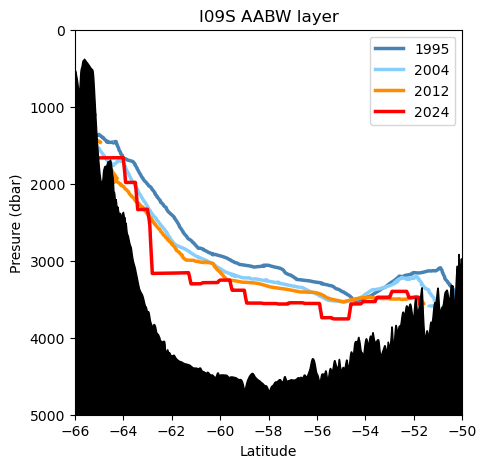

In [9]:
plt.figure(figsize = (5, 5))
for t in range(0, len(I09S['gridded_section'])):
    I09S_south_basin['gamma'].isel(gridded_section = t).squeeze().plot.contour(levels = [28.27], colors = colours[t],
                                                                                linewidths = [2.5])

plt.legend(handles = legend_entry)
plt.fill_between(bathy_south['z']['lat'], 6000, -bathy_south['z'], color = 'k', zorder = 2)
plt.gca().invert_yaxis()
plt.title('I09S AABW layer')
plt.xlabel('Latitude')
plt.ylabel('Presure (dbar)');
plt.ylim(5000, None);
plt.xlim(-66, -50);

As we saw on the previous notebook, our interpolation is rougher than the Easy Ocean's product. Particularly, south of around 62$^{\circ}$S there is this step change in the bottom layer, which is due, if you remember, that in the MISO voyage these stations were taken a few degrees of longitude west than the others. We can still work with this, but it is good to know and keep it mind!

There is a noticeable shrinking of this layer, particularly large in the last occupation. We can also look at what has happened north of the ridge. Remember from our pathway schematic in the introduction that AABW has traveled a fair distance before escaping through the deep openings in the ridge. As it travels, AABW mixes with the less dense layers above it, and overall reduces its original density a little bit. So instead of the 28.27 kg/m$^3$ contour, we will use a slightly smaller value of 27.20 kg/m$^3$ north of the ridge.

In [10]:
I09S_north_basin = I09S.sel(latitude = slice(-48, -35))
bathy_north = bathymetry.sel(lat = slice(-48, -35))

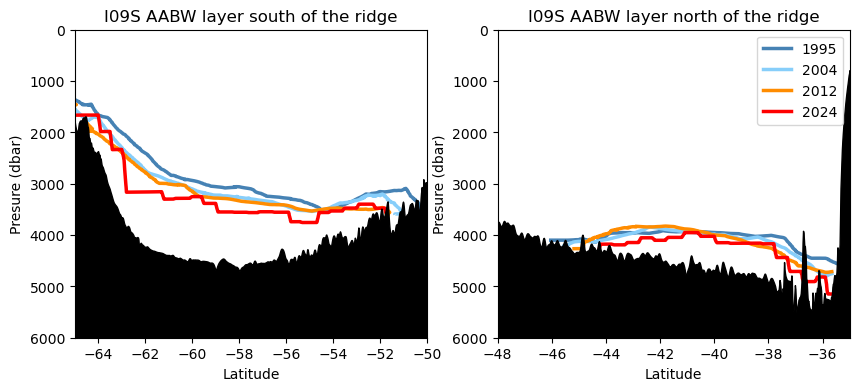

In [20]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))
for t in range(0, len(I09S['gridded_section'])):
    I09S_south_basin['gamma'].isel(gridded_section = t).squeeze().plot.contour(ax = axs[0], levels = [28.27], colors = colours[t],
                                                                               linewidths = [2.5])
    I09S_north_basin['gamma'].isel(gridded_section = t).squeeze().plot.contour(ax = axs[1], levels = [28.20], colors = colours[t],
                                                                               linewidths = [2.5])
axs[0].fill_between(bathy_south['z']['lat'], 6000, -bathy_south['z'], color = 'k', zorder = 2)
axs[1].fill_between(bathy_north['z']['lat'], 6000, -bathy_north['z'], color = 'k', zorder = 2)
axs[1].legend(handles = legend_entry)
axs[0].set_title('I09S AABW layer south of the ridge')
axs[1].set_title('I09S AABW layer north of the ridge')
axs[0].set_xlim(-65, -50)
for ax in axs:
    ax.invert_yaxis()
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Presure (dbar)');
    ax.set_ylim(6000, None);

The changes are less pronounced north of the ridge, possibly because of the prolonged travel time: AABW takes many years to escape northwards after its formation around in the Adelie land and Ross Sea. 

# Quantifying changes

<div style="float: right; margin-right: 20px; margin-left: 30px; width: 30%;">
    <img src="images/grid_schematic.png" width="100%"/>
</div>

Now that we have identified the AABW layer, we can start analysing what has changed within it. Has it's average temperature gone up? What has happened to its salt/oxygen content? 

We will start by calculating the area occupied by the AABW layer in each occupation, to put a number to the shrinking we saw in the previous figure. In order to do this, we need to integrate all the area where neutral densities are higher than 28.27 kg/m$^3$. What do we mean by this?

Remember that we have gridded data, where each value represents an average within a grid-cell. These grid-cells have dimensions, i.e. have a width and have a depth, and therefore have an area. If we want to know the area occupied by the AABW layer, we need to find the grid-cells where the neutral density satisfies our criteria, and sum the area of all the grid-cells we found. Something like the schematic on the right. We can write that in math form:

$$
A_{AABW} = \sum_{i, j} A_{i,j} = \sum_{i, j} dz_j \times dx_i 
$$

The height of our grid-cells, $dz_i$ can be obtained from our pressure coordinate. We just need to convert pressures to depths, and then calculate the difference between subsequent levels. 

The length of our grid-cells, $dx_j$ is given by the meridional distance between the latitude coordinates.

## Calculating area of grid cells
Let's begin by calculating our $dz$. We will convert pressure to depth using `gsw`:

In [21]:
depth = gsw.z_from_p(I09S_south_basin['pressure'], I09S_south_basin['latitude'])
depth = depth.rename('depth')
# Depths are given in negative distance from the surface, so we will multiply by -1 to obtain positive depths
depth = -1 * depth 

To calculate $dz$ from our depth array, we can use the `xarray.diff()` function, which calculates the difference between subsequent points in an array along the specified dimension, so that:
$$
dz_{i+1} = z_{i+1} - z_{i}
$$

Notice how our $dz$ can not have a value at surface because there is no $z_{-1}$! We need to remember this in a future step.

In [27]:
dz = depth.diff(dim = 'pressure')
dz

<xarray.DataArray 'depth' (pressure: 650, latitude: 155)> Size: 806kB
array([[9.9014683 , 9.90153767, 9.90160724, ..., 9.91386623, 9.91395629,
        9.91404641],
       [9.90098759, 9.90105695, 9.90112652, ..., 9.91338489, 9.91347494,
        9.91356505],
       [9.90050703, 9.90057638, 9.90064595, ..., 9.9129037 , 9.91299375,
        9.91308385],
       ...,
       [9.61949333, 9.61956062, 9.61962811, ..., 9.63152102, 9.63160839,
        9.63169581],
       [9.61909938, 9.61916667, 9.61923416, ..., 9.63112656, 9.63121392,
        9.63130134],
       [9.61870556, 9.61877285, 9.61884034, ..., 9.63073222, 9.63081958,
        9.63090699]])
Coordinates:
  * pressure  (pressure) float64 5kB 10.0 20.0 30.0 ... 6.49e+03 6.5e+03
  * latitude  (latitude) float64 1kB -65.4 -65.3 -65.2 ... -50.2 -50.1 -50.0

Now let's calculate our $dx$. We have latitude coordinates in degrees in our I09S array and we know they are spaced by 0.1$^{\circ}$ latitude. We need to convert that distance into metres. Distance between latitude points are easy since  0.1$^{\circ}$ latitude are the same distance in metres everywhere! The same does not happen for  0.1$^{\circ}$ longitude because we need to account for the Earth's curvature.  At the Equator, 0.1$^{\circ}$ is more distance in metres than at the Antarctic margins.

But let's not worry about that. One degree latitude is 111 km, so our $dx$ will be: 
$$
dx \sim 111000m \times 0.1
$$

In [22]:
dx = 111000 * 0.1

#### Question 1

How would you calculate a distance between two *longitude* points instead?

*Answer here*

Now we can calculate our area: 

In [28]:
area = dx * dz
area = area.rename('area')

## Masking the AABW layer

Now we want to select the region in our `area` array corresponding to the AABW layer and sum it to obtain the total area of the layer. We can do that by:

1. Creating a mask that identifies the gridboxes with AABW density values,
2. Apply that mask to the `area` array
3. Summing the masked areas 

We will create a mask that has 1s for regions with AABW, `NaN`s everywhere else.

In [24]:
AABW_layer_mask = xr.where(I09S_south_basin['gamma'] >= 28.27, 1, np.nan).rename('mask')
AABW_layer_mask

<xarray.DataArray 'mask' (pressure: 651, latitude: 155, longitude: 1,
                          gridded_section: 4)> Size: 3MB
array([[[[nan, nan, nan, nan]],

        [[nan, nan, nan, nan]],

        [[nan, nan, nan, nan]],

        ...,

        [[nan, nan, nan, nan]],

        [[nan, nan, nan, nan]],

        [[nan, nan, nan, nan]]],


       [[[nan, nan, nan, nan]],

        [[nan, nan, nan, nan]],

        [[nan, nan, nan, nan]],
...
        [[nan, nan, nan, nan]],

        [[nan, nan, nan, nan]],

        [[nan, nan, nan, nan]]],


       [[[nan, nan, nan, nan]],

        [[nan, nan, nan, nan]],

        [[nan, nan, nan, nan]],

        ...,

        [[nan, nan, nan, nan]],

        [[nan, nan, nan, nan]],

        [[nan, nan, nan, nan]]]])
Coordinates:
  * gridded_section  (gridded_section) float64 32B 1.0 2.0 3.0 4.0
  * longitude        (longitude) float64 8B 114.7
  * latitude         (latitude) float64 1kB -65.4 -65.3 -65.2 ... -50.1 -50.0
  * pressure         (pressure) float64 5kB 0.0 10.0 20.0 ... 6.49e+03 6.5e+03

And so now if we multiply the area by the mask, the `NaN`s will mask out everything that is not AABW:

In [42]:
AABW_layer_areas = AABW_layer_mask * area

Let's verify we have selected the correct regions:

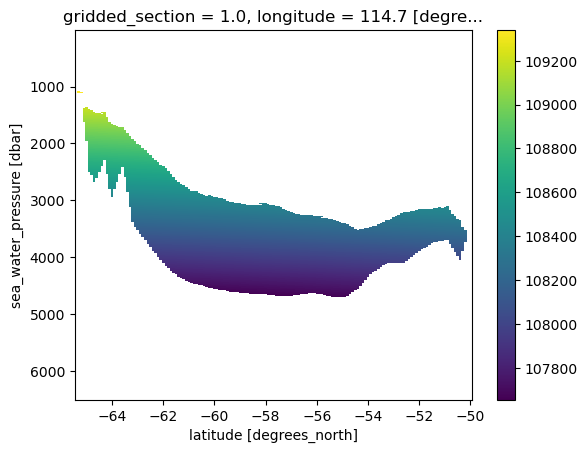

In [30]:
AABW_layer_areas.squeeze().isel(gridded_section = 0).plot()
plt.gca().invert_yaxis()

#### Question 2

Notice how the areas decrease with depth. Why do you think that's the case? Remember that in the original dataset, we have a uniform pressure dimension, with data every 10 dBar.

*Answer here*

Now we can sum (integrate) to get the total area of the layer:

In [37]:
AABW_area = AABW_layer_areas.sum(['latitude', 'pressure']).squeeze().rename('AABW_area')
AABW_area.attrs['units'] = 'm2'

Let's plot, dividing by 1e6 to get the units in million m$^2$!

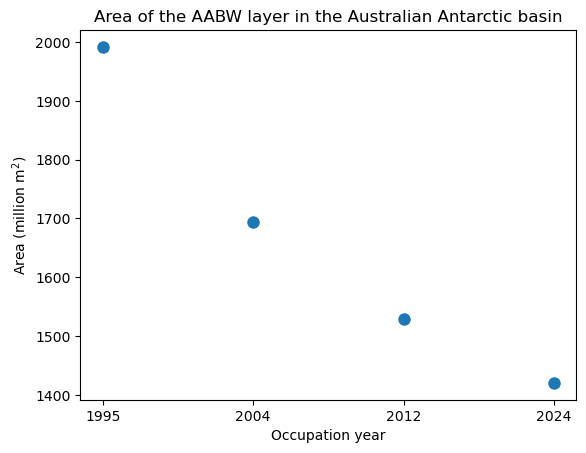

In [40]:
(AABW_area/1e6).plot.scatter(s = 100);
plt.ylabel('Area (million m$^2$)')
plt.xticks([1,2,3,4], years)
plt.xlabel('Occupation year');
plt.title('Area of the AABW layer in the Australian Antarctic basin');

From 1995 to 2024, the AABW layer has reduced in around 25%. This probably has its roots in the warming climate, in the freshening caused by melting of glaciers and ice sheets, etc. 

This calculation has shown you how to select the AABW layer. You can use this method to calculate other properties for this layer.

#### Question 3

Use the code above, specifically the `AABW_layer_mask` to calculate the average conservative temperature, absolute salinity and oxygen in the AABW layer. Plot these three together with the area of the layer in the same figure, with four different panels. 

You can use [CoPilot](https://copilot.microsoft.com/) to help you!

Try to get the following figure:

In [50]:
AABW_temp = (AABW_layer_mask * I09S_south_basin['conservative_temperature']).mean(['pressure', 'latitude'])
AABW_salt = (AABW_layer_mask * I09S_south_basin['absolute_salinity']).mean(['pressure', 'latitude'])
AABW_oxyg = (AABW_layer_mask * I09S_south_basin['oxygen']).mean(['pressure', 'latitude'])

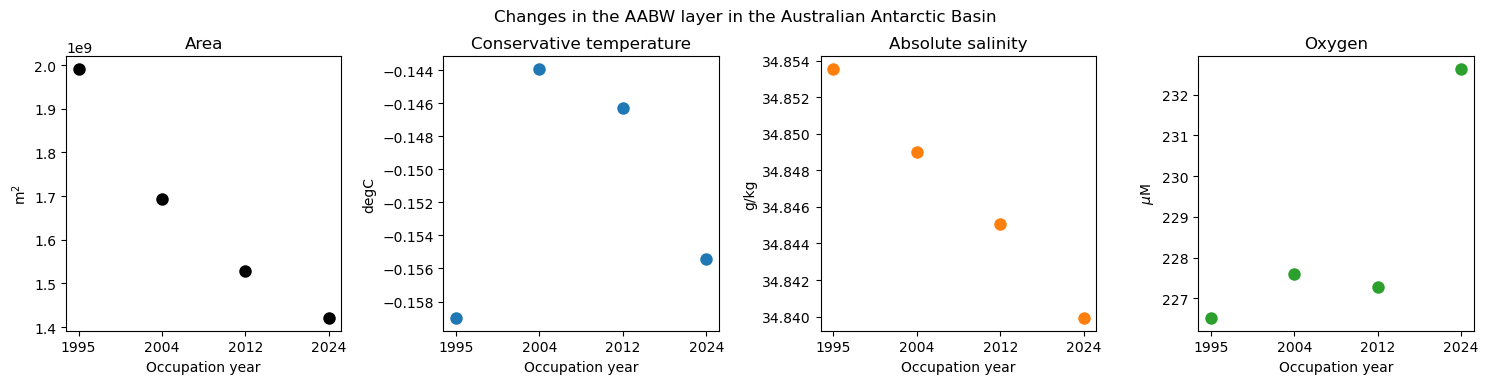

In [53]:
fig, axs = plt.subplots(1, 4, figsize = (15, 4))

AABW_area.plot.scatter(ax = axs[0], s = 100, c = 'k');
AABW_temp.plot.scatter(ax = axs[1], s = 100, c = 'C0');
AABW_salt.plot.scatter(ax = axs[2], s = 100, c = 'C1');
AABW_oxyg.plot.scatter(ax = axs[3], s = 100, c = 'C2');

for ax in axs:
       ax.set_xticks([1,2,3,4], years)
       ax.set_xlabel('Occupation year');

axs[0].set_ylabel('m$^{2}$')
axs[0].set_title('Area')
axs[1].set_ylabel('degC')
axs[1].set_title('Conservative temperature')
axs[2].set_ylabel('g/kg')
axs[2].set_title('Absolute salinity')
axs[3].set_ylabel('$\mu$M')
axs[3].set_title('Oxygen');
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Changes in the AABW layer in the Australian Antarctic Basin');

#### Question 3

Repeat the calculations for the basin north of the ridge (our `I09S_north_basin`). This time, you are going to have to create a different mask. Think about the following questions:

**a.** How are the changes different from the southern basin? Look at the magnitudes!
 
**b.** What do you think these differences are attributed to?

*Answer here*